In [1]:
from pathlib import Path

import torch
from torch import nn
from fiftyone import ViewField as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
from tqdm import tqdm

from src.data.torch_dataset import make_tmod_dataloader, get_mean_std
from src.data.fo_dataset import load_all_splits_as_one
from src.eval import eval_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
dataset_root = Path("data")
dataset = load_all_splits_as_one(dataset_root, ['train', 'valid', 'test'])

image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in dataset])

Using device: cuda
 100% |█████████████████| 360/360 [170.6ms elapsed, 0s remaining, 2.1K samples/s]  
 100% |█████████████████| 101/101 [62.3ms elapsed, 0s remaining, 1.6K samples/s]      
 100% |███████████████████| 51/51 [39.0ms elapsed, 0s remaining, 1.3K samples/s]      


In [2]:
import wandb
wandb.login(relogin=True) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chychiang (raun). Use `wandb login --relogin` to force relogin


True

In [3]:
# filter out images no detection
training_samples = dataset.match(F("detections").exists())
train_img_paths, train_sample_ids = zip(*[(s.filepath, s.id) for s in training_samples])

In [4]:
class CustomBackbone(nn.Module):
    def __init__(self, grayscale=False):
        super().__init__()
        self.input_channels = 1 if grayscale else 3
        self.model = nn.Sequential(
            nn.Conv2d(self.input_channels, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(3136, 256),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.model(x)

class Detector(nn.Module): 
    def __init__(self, output_dim=4, grayscale=False):
        super().__init__()
        self.backbone = CustomBackbone(grayscale=grayscale)
        self.bbox_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, output_dim),
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.bbox_head(x)

model = Detector(grayscale=False)
model.to(device)

from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
         LeakyReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,928
         LeakyReLU-5           [-1, 64, 56, 56]               0
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          36,928
         LeakyReLU-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
           Conv2d-10           [-1, 64, 14, 14]          36,928
        LeakyReLU-11           [-1, 64, 14, 14]               0
        MaxPool2d-12             [-1, 64, 7, 7]               0
          Flatten-13                 [-1, 3136]               0
           Linear-14                  [

In [5]:
def full_iteration(dataloader, dataset, model, loss_fn, optim):
    model.train()
    total_loss = 0
    for imgs, img_ids in dataloader:
        # get bounding box labels
        bounding_boxes_gt = dataset[img_ids].values('detections.detections.bounding_box')
        bounding_boxes_gt = torch.tensor(bounding_boxes_gt).squeeze(1) * imgs.shape[-1] # scale to image size

        x1 = bounding_boxes_gt[:, 0]
        y1 = bounding_boxes_gt[:, 1]
        x2 = x1 + bounding_boxes_gt[:, 2]
        y2 = y1 + bounding_boxes_gt[:, 3]
        bounding_boxes_gt = torch.stack([x1, y1, x2, y2], dim=1) # convert to x1, y1, x2, y2 format

        # move to GPU
        imgs = imgs.to(device)
        bounding_boxes_gt = bounding_boxes_gt.to(device)

        # training
        optim.zero_grad()
        preds = model(imgs)

        # bounding box loss 
        loss = loss_fn(preds, bounding_boxes_gt)

        # centerness loss
        center_gt = (bounding_boxes_gt[:, 2:] + bounding_boxes_gt[:, :2]) / 2
        center_preds = (preds[:, 2:] + preds[:, :2]) / 2
        center_loss = torch.nn.functional.l1_loss(center_preds, center_gt)

        loss += center_loss

        loss.backward()
        optim.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [6]:
config = {
    'learning_rate': 1e-4,
    'batch_size': 32,
    'epochs': 400,
    'loss': 'MSE',
    'loss_reduction': 'mean',
}

debug = False
if not debug:
    run = wandb.init(
        # Set the project where this run will be logged
        project="tmod",
        # Track hyperparameters and run metadata
        config=config,
    )

dataloader, transforms = make_tmod_dataloader(train_img_paths, 
                                              train_sample_ids,
                                              batch_size=config['batch_size'],
                                              num_workers=8)

mean, std, min_val, max_val = get_mean_std(dataloader)
print(f"Mean: {mean}, Std: {std}")
print(f"Min: {min_val}, Max: {max_val}")


if config['loss'] == 'L1':
    loss_fn = torch.nn.L1Loss(reduction=config['loss_reduction'])
elif config['loss'] == 'MSE':
    loss_fn = torch.nn.MSELoss(reduction=config['loss_reduction'])
elif config['loss'] == 'SmoothL1':
    loss_fn = torch.nn.SmoothL1Loss(reduction=config['loss_reduction'])

optim = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

pbar = tqdm(range(config['epochs']))
for epoch in pbar:
    iteration_loss = full_iteration(dataloader, training_samples, model, loss_fn, optim)
    pbar.set_description(f"Epoch {epoch} | Loss {iteration_loss:.4f}")
    if not debug:
        wandb.log({"loss": iteration_loss})

Mean: tensor([3.3479e-07, 3.1480e-07, 3.0178e-07]), Std: tensor([1.2503e-07, 1.2132e-07, 1.2377e-07])
Min: 0.0, Max: 0.9983512759208679


Epoch 399 | Loss 2512.7140: 100%|██████████| 400/400 [05:45<00:00,  1.16it/s]


/tmp/ipykernel_3764/3169286586.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).float().unsqueeze(0)


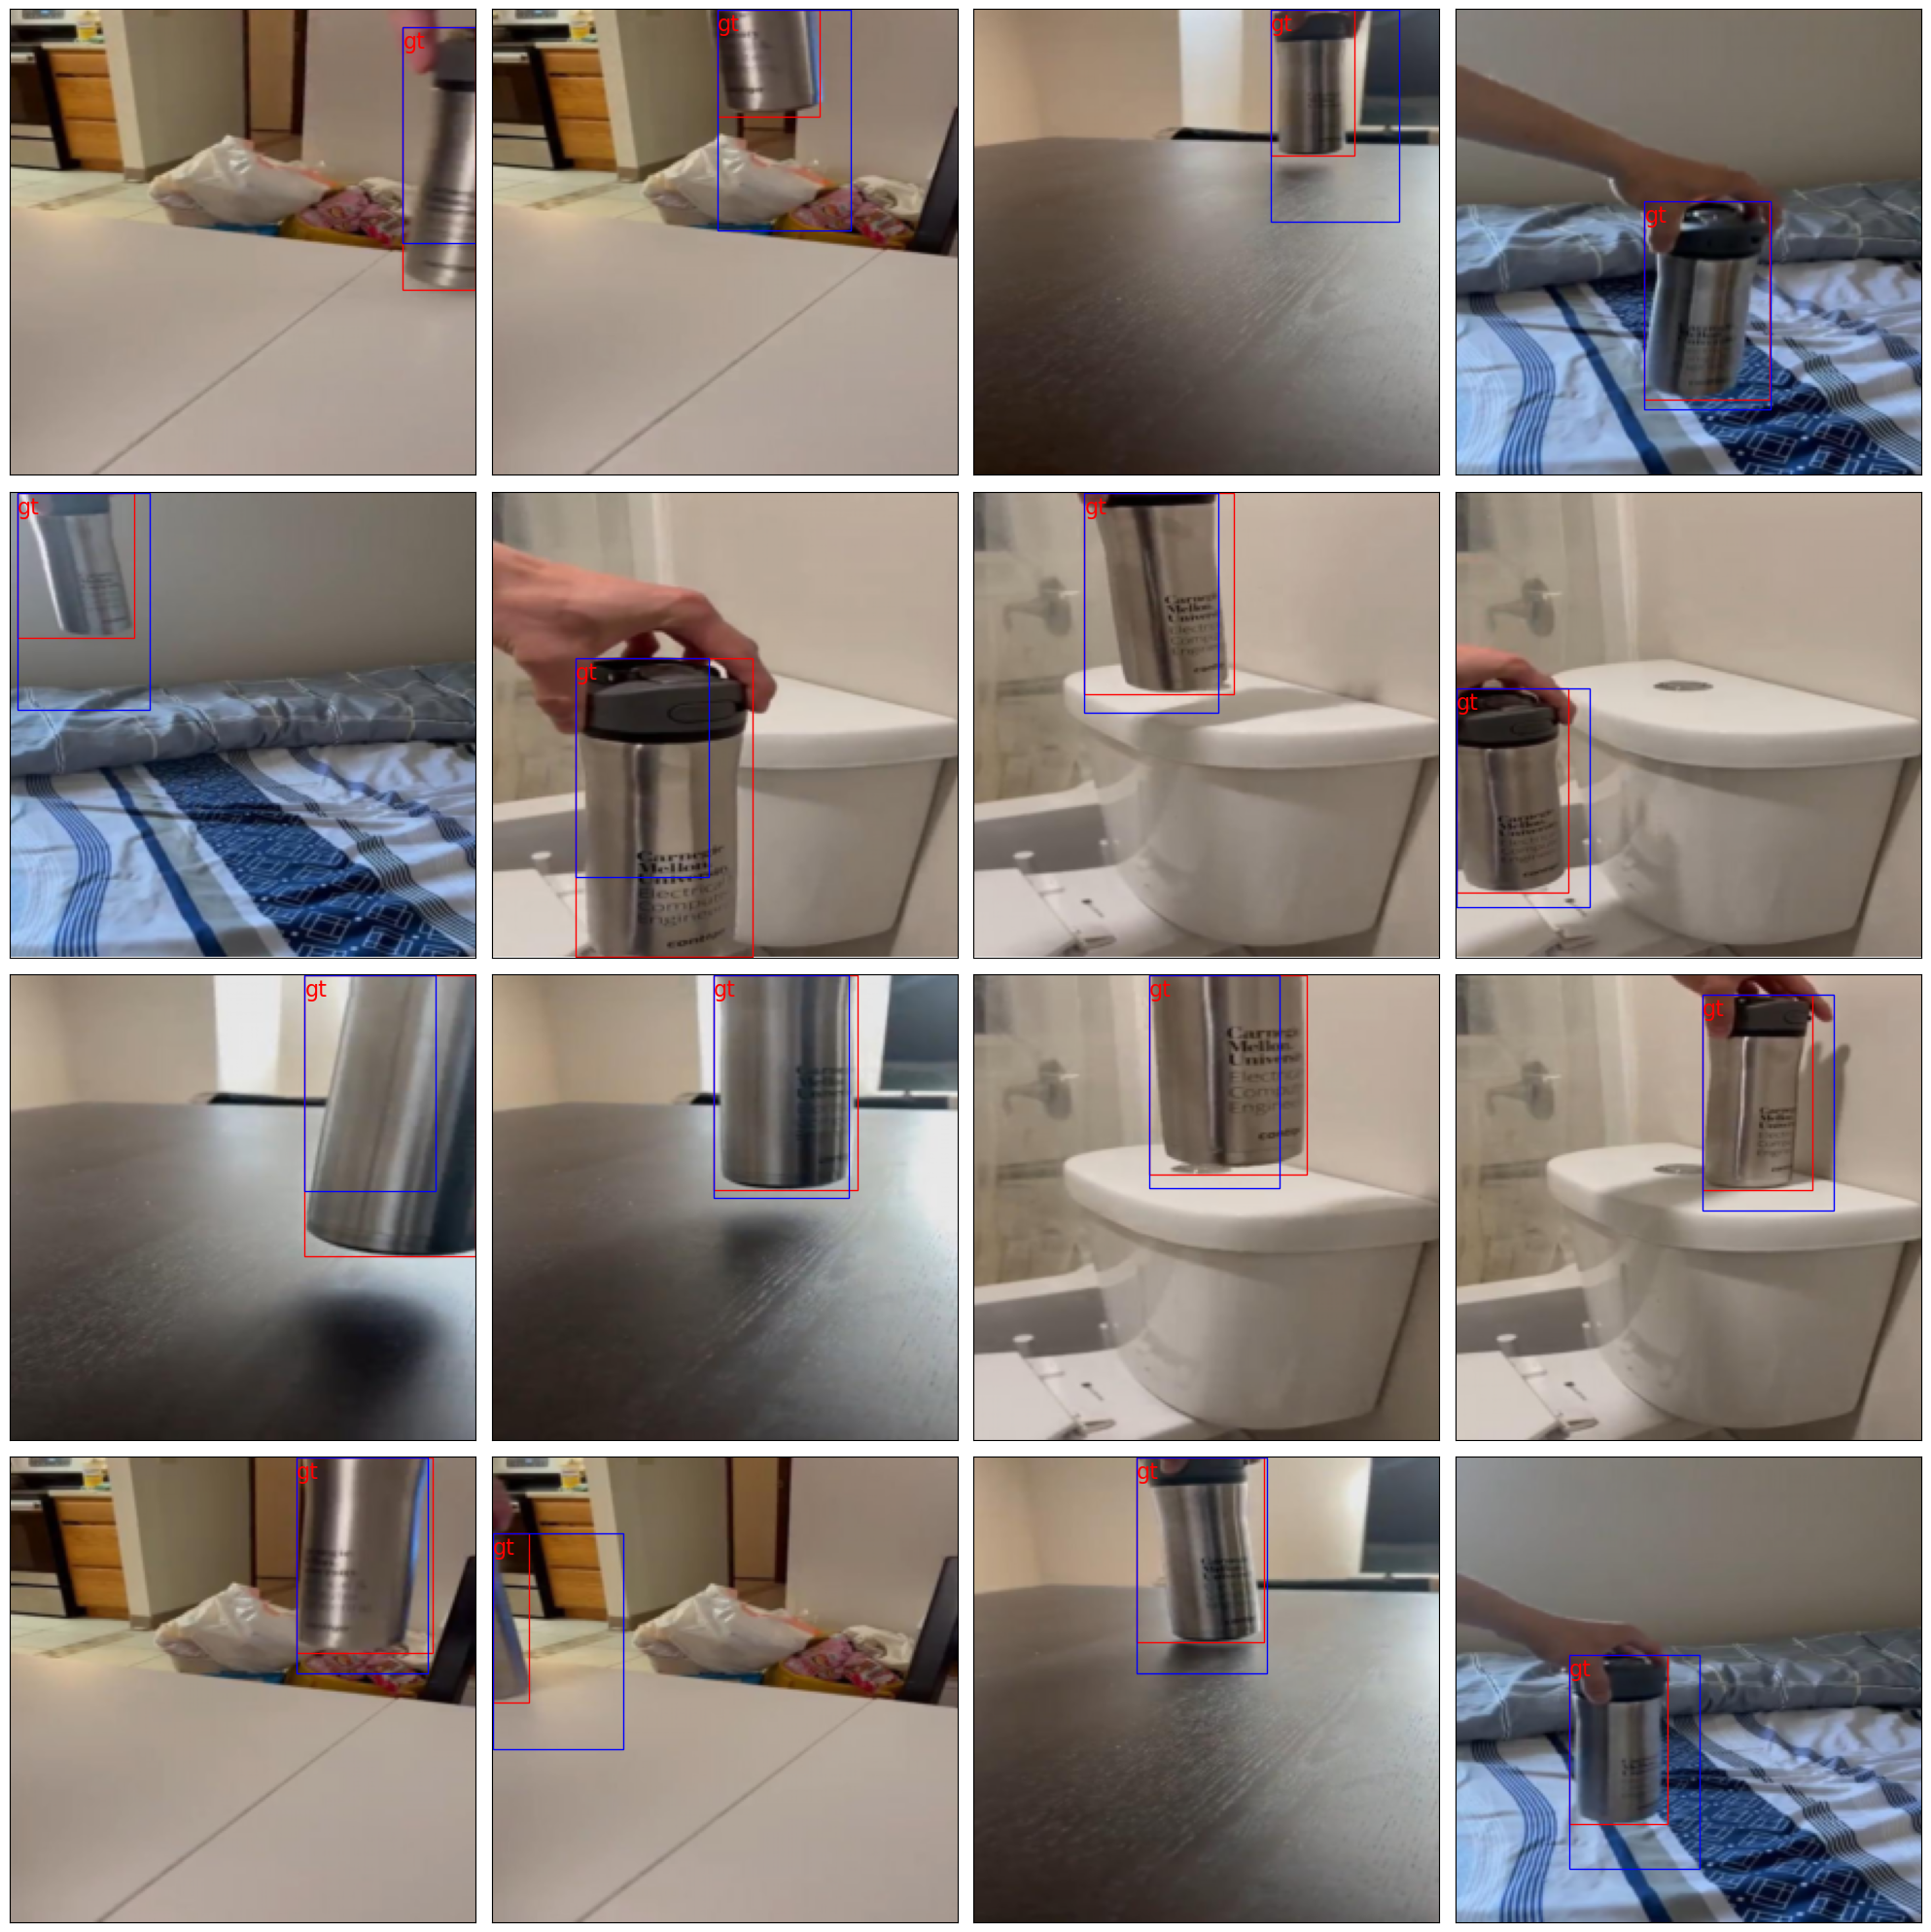

In [7]:
# predict on a single image and visualize
import numpy as np


# take samples
samples = training_samples.take(16, seed=1)
model.eval()

xaxis = 4
yaxis = 4
plt.figure(figsize=(20, 20))
for i, sample in enumerate(samples):
    plt.subplot(yaxis, xaxis, i+1)

    # plot image
    img = Image.open(sample.filepath)
    plt.xticks([])
    plt.yticks([])

    # inference
    img = np.array(img)
    img = transforms(img)
    transformed_img = img.numpy().transpose(1, 2, 0)
    plt.imshow(transformed_img, cmap='gray')

    img = torch.tensor(img).float().unsqueeze(0)
    img = img.to(device)
    preds = model(img)
    preds = preds.cpu().detach().numpy().squeeze()

    # draw gt bounding box
    bbox = sample.detections.detections[0].bounding_box
    top_left_x, top_left_y, width, height = np.array(bbox) * 224
    rect = plt.Rectangle((top_left_x, top_left_y), width, height, edgecolor='r', facecolor='none')
    plt.text(top_left_x, top_left_y+10, 'gt', color='r', fontsize=16)
    plt.gca().add_patch(rect)

    # draw pred bounding box
    x1, y1, x2, y2 = np.array(preds)

    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((top_left_x, top_left_y), width, height, edgecolor='b', facecolor='none')
    plt.gca().add_patch(rect)


plt.tight_layout()

if not debug:
    wandb.log({"charts": plt})

In [8]:
ious = eval_model(model, training_samples, transforms, device)

  0%|          | 0/356 [00:00<?, ?it/s]/home/ben/tmod/src/eval.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).float().unsqueeze(0)
100%|██████████| 356/356 [00:01<00:00, 298.76it/s]

Mean IoU: 0.33264534071528373


In [9]:
def mAP(ious, threshold=0.5):
    return np.mean(np.array(ious) > threshold)

mAP(ious, threshold=0.5)

0.2556179775280899

In [10]:
torch.save(model.state_dict(), 'model.pth')

In [11]:
run.finish()

loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,2512.71401
